# Image deblurring
Image deblurring is the process of removing artifacts from images. An out of focus camera or movement during the exposure can cause these artifacts. This is often modeled as a convolution of the undistorted image with a point spread function. Deblurring is the inversion of this model. Inverse problems are often solved in an iterative manner. A simple example of this will be shown in this notebook.  
If the point spread function is unknown, this problem is also known as [blind deconvolution](https://en.wikipedia.org/wiki/Blind_deconvolution). Here we assume to know the point spread function. Therefore, this problem can be easily written as an optimization problem. The loss is the root mean square error of the predicted, convolved image with the blurred image. This value is minimized with regard to the predicted sharp image.  
We use [TensorFlow](https://www.tensorflow.org/) to solve this problem. TensorFlow is similar to numpy, since it is a package with math and scientific computation functionalities. The difference is, that TensorFlow is executed lazily. That means the computation graph is completely build before the computation is actually done. This allows TensorFlow to calculate the derivative of the computation graph, which is very handy for neural networks and complex problems in general, because manually deriving a complex function is tedious and error prone.  
We try out the deblurring procedure on the astronaut image from skimage. It is resized by 1/3. This makes the execution much faster. However the algorithm can be applied on much larger images in the same way.

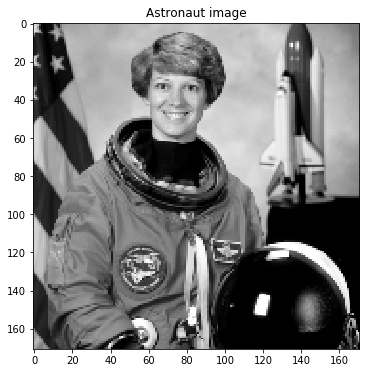

In [1]:
%matplotlib inline
from skimage import color, data
from skimage.transform import rescale
import matplotlib.pyplot as plt

astro_org = rescale(color.rgb2gray(data.astronaut()), 1.0/3.0, mode='constant')

plt.figure(figsize=(6, 6))
plt.gray()
plt.imshow(astro_org)
plt.title('Astronaut image');

Next we define and implement necessary functions. The function gaussian returns the gaussian bell function as a numpy array. It is used to create the point spread function. In addition there are two 2D convolution functions implemented. One for numpy arrays and one of TensorFlow arrays, but otherwise they are the same.

In [2]:
import numpy as np
import tensorflow as tf
import scipy.ndimage.filters as fi


def gaussian(kernlen, nsig_x, nsig_y):
    inp = np.zeros((kernlen, kernlen))
    inp[kernlen//2, kernlen//2] = 1
    kern = fi.gaussian_filter(inp, (nsig_x, nsig_y))
    scaled_kern = kern / np.sum(kern)
    return scaled_kern


def tf_convolve_2d(image, psf):
    tf_image = tf.reshape(image, (1, tf.shape(image)[0], tf.shape(image)[1], 1))
    tf_psf = tf.reshape(psf, (tf.shape(psf)[0], tf.shape(psf)[1], 1, 1))
    tf_output = tf.nn.conv2d(tf_image, tf_psf, [1, 1, 1, 1], 'SAME')[0, :, :, 0]
    return tf_output


def convolve(image, psf):
    sess = tf.Session()
    tf_image = tf.constant(image, dtype=tf.float32)
    tf_psf = tf.constant(psf, dtype=tf.float32)
    tf_output = tf_convolve_2d(tf_image, tf_psf)
    output = sess.run(tf_output)
    return output

The following image shows us the point spread function. The gaussian has a larger standard deviation in the y-direction. This models motion blur into the y-direction. 

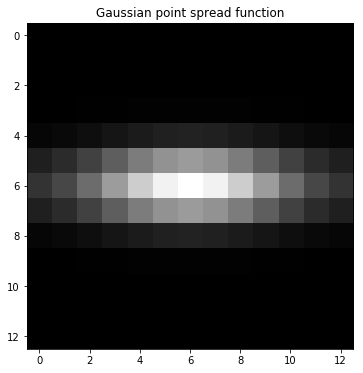

In [3]:
psf = gaussian(kernlen=13, nsig_x=1, nsig_y=3)

plt.figure(figsize=(6, 6))
plt.imshow(psf)
plt.title('Gaussian point spread function');

Now we convolve the original astronaut image with our previously defined point spread function. You can see the result in the following image.

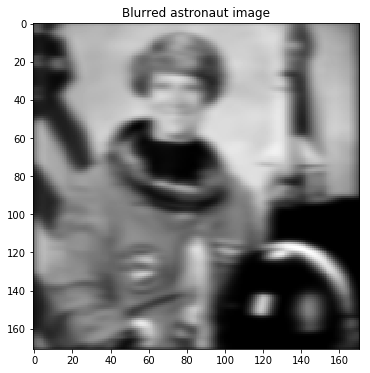

In [4]:
astro_blur = convolve(astro_org, psf)

plt.figure(figsize=(6, 6))
plt.imshow(astro_blur)
plt.title('Blurred astronaut image');

The deconvolution is implemented as an optimization problem. The loss is the deviation of the given image (original convolved astronaut image) to the estimated convolved image. This problem can be solved by gradient decent. TensorFlow implements a gradient decent optimizer. Therefore, we don't have to do the tedious and error prone work of deriving this function manually. If you want you could take a different optimizer, like Adam or Adagrad. These optimizers might find the optimum faster, but have more parameters to tune.  
Deconvolution is an ill-conditioned problem. Therefore, this problem should be regularized, which is done here. We use the L2-norm of the deconvolved image. Not using a regularization leads to very noisy results.  

In [5]:
def deconvolve(image, psf, learning_rate=5e-1, mu=0.2):
    loss_history = []

    tf_input = tf.Variable(np.random.randn(*image.shape) / 10.0, dtype=tf.float32)
    tf_psf = tf.constant(psf, dtype=tf.float32)
    tf_gt_output = tf.constant(image, dtype=tf.float32)
    tf_output = tf_convolve_2d(tf_input, tf_psf)

    output_loss = tf.sqrt(tf.nn.l2_loss(tf_output - tf_gt_output))
    regularization = tf.sqrt(tf.nn.l2_loss(tf_input[:-1, :] - tf_input[1:, :]) + tf.nn.l2_loss(tf_input[:, :-1] - tf_input[:, 1:]))
    loss = output_loss + mu * regularization
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)

    train = optimizer.minimize(loss)

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    def eval_step(i=0):
        tmp_loss = sess.run(loss)
        loss_history.append(tmp_loss)
        if i % 100 == 0:
            print('loss: {}'.format(tmp_loss))

    eval_step()
    for i in range(500):
        sess.run(train)
        eval_step(i)
    res_input = sess.run(tf_input)

    return res_input, loss_history

Now we actually perform the deconvolution. It takes some seconds. The loss is plotted against the iterations. It can be seen, that the optimum is found quite easily.

In [ ]:
astro_deconv, loss = deconvolve(astro_blur, psf)

plt.figure(figsize=(6, 6))
plt.plot(loss)
plt.title('Loss');

loss: 65.60228729248047
loss: 65.31267547607422
loss: 37.720794677734375
loss: 15.045373916625977


Let's plot all interesting images side by side. Left is the original astronaut image. We want to calculate this image from the blurred image in the middle. Our simple deblurring algorithm gives the right image. The result is much sharper than the blurred image. We see some ringing effects at nearby high intensity changes. As I already mentioned this is a very ill-conditioned problem. The result depends a lot on the prior information. In our case that is the regularization.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))

for a in ax:
    a.axis('off')

ax[0].imshow(astro_org, vmin=astro_org.min(), vmax=astro_org.max())
ax[0].set_title('Original data')

ax[1].imshow(astro_blur, vmin=astro_org.min(), vmax=astro_org.max())
ax[1].set_title('Blurred data')

ax[2].imshow(astro_deconv, vmin=astro_org.min(), vmax=astro_org.max())
ax[2].set_title('Deconvolved data')

fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)

We have seen how to convolve a sharp image to get a blurry one and how to deblur it again. Deblurring is the inverse problem to a convolution, therefore the other name "deconvolution". This problem is described by an optimization problem, which can be solved with gradient decent. Our main tool is TensorFlow. It does a lot of the otherwise tedious work for us and implements autograd and gradient descent. 